# t-PFD To PFD
This script convert t-PFD to pt-PFD. The input file and output file must be defined bt user.

In [1]:
inputdir = 'PFS/fermi-1-1/f-10000-comp/'
outputdir = 'pPFS/fermi-1-1/f-10000-comp/'

In [2]:
npfd = 7
etal1 = np.loadtxt(inputdir + 'etal1_{}'.format(npfd), dtype=complex)
expn1 = np.loadtxt(inputdir + 'expn1_{}'.format(npfd), dtype=complex)
print(expn1, etal1)

[2.78740655e+00+0.j 4.28839664e-01+0.j 9.02371451e-02+0.j
 1.96584997e-02+0.j 4.31172630e-03+0.j 1.01962506e-03+0.j
 2.94867229e-04+0.j 1.00000000e+00-0.j] [ 0. +3.22863093e-01j -0. -2.70710231e-01j -0. -4.42166532e-02j
 -0. -9.54212247e-03j -0. -2.06532138e-03j -0. -4.18617529e-04j
 -0. -1.74594084e-04j  0.5+0.00000000e+00j]


In [3]:
# import math
from cvxopt import solvers, matrix, spmatrix, mul
from scipy import sparse
from numpy import linalg as LA


def numpy_to_cvxopt_matrix(A):
    if A is None:
        return A
    if sparse.issparse(A):
        if isinstance(A, sparse.spmatrix):
            return scipy_sparse_to_spmatrix(A)
        else:
            return A
    else:
        if isinstance(A, np.ndarray):
            if A.ndim == 1:
                return matrix(A, (A.shape[0], 1), 'd')
            else:
                return matrix(A, A.shape, 'd')
        else:
            return A
        

def fFeim(x, pole, resi, sigma=1):
    return 1 / 2 - sigma * sum(2.0 * resi[i] * x / (x**2 + pole[i]**2)
                               for i in range(len(pole)))


def tseig(D, E):
    mat = np.diag(E, -1) + np.diag(D, 0) + np.diag(E, 1)
    return -np.sort(-np.linalg.eigvalsh(mat))


def PSD(N, BoseFermi=2):
    pole, resi = [], []
    if N > 0:
        M = 2 * N + 1 // 2
        temp = 3 if BoseFermi == 1 else 1
        diag = np.zeros(M, dtype=float)
        doff = np.array([
            1 / math.sqrt((temp + 2 * i) * (temp + 2 * (i + 1)))
            for i in range(M - 1)
        ])
        pole = 2 / tseig(diag, doff)[:N]
        pol2 = np.array([x * x for x in pole])
        M -= 1
        temp = 5 if BoseFermi == 1 else 3
        diag = np.zeros(M, dtype=float)
        doff = np.array([
            1.0 / math.sqrt((temp + 2 * i) * (temp + 2 * (i + 1)))
            for i in range(M - 1)
        ])
        M //= 2
        eig2 = np.power(2 / tseig(diag, doff)[:M], 2)

        scaling = 0
        if BoseFermi == 1:
            scaling = N*(2 * N + 3)
        elif BoseFermi == 2:
            scaling = N*(2 * N + 1)
        resi = np.zeros(N, dtype=float)
        for j in range(N):
            if j == N - 1:
                temp = 0.5 * scaling
            else:
                temp = 0.5 * scaling * (eig2[j]-pol2[j])/(pol2[N-1]-pol2[j])
            for k in range(M):
                temp *= (eig2[k]-pol2[j]) / \
                    (pol2[k]-pol2[j]) if k != j else 1.0
            resi[j] = temp
    return pole, resi


def decompose_spe(spe,
                  sp_para_dict,
                  para_dict,
                  condition_dict,
                  npsd,
                  sigma,
                  pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)

    expn = np.array([])
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn = np.append(expn, -sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []
    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]
    expn_val_cc = []
    expn_val_n_cc = expn
    expn = list(expn[expn_imag_sort])
    pole, resi = PSD(npsd, 2)
    beta = para_dict['beta']
    temp = 1 / beta

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 2.j * numer_get_para / np.multiply.reduce(
                    w_sp - poles_allplane[np.abs(poles_allplane - sigma * 1.J *
                                                 expn_val_n_cc[ii]) > 1e-14])
                      ).subs({w_sp: sigma * 1.j * expn_val_n_cc[ii]}) *
                     fFeim(sigma * 1.J * expn_val_n_cc[ii] / temp, pole, resi,
                           sigma))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    f = numer_get_para / np.multiply.reduce(w_sp - poles_allplane)
    f = sp.lambdify(w_sp, f)

    for inma in range(len(pole)):
        zomg = sigma * 1.J * pole[inma] * temp
        jsum = np.sum(f(zomg))
        expn.append(pole[inma] * temp)
        etal.append(-2.J * resi[inma] * temp * jsum)
        etar.append(np.conj(etal[-1]))
        etaa.append(np.abs(etal[-1]))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)
    return etal, etar, etaa, expn


def decompose_spe_real(spe,
                       sp_para_dict,
                       para_dict,
                       condition_dict,
                       sigma,
                       pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []
    expn = np.array(expn)
    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]
    expn_val_cc = []
    expn_val_n_cc = expn
    expn = list(expn[expn_imag_sort])

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 1.j * numer_get_para /
                      np.multiply.reduce(w_sp - poles_allplane[np.abs(
                          poles_allplane -
                          sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])).subs(
                              {w_sp: sigma * 1.j * expn_val_n_cc[ii]}))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)
    return etal, etar, etaa, expn


@njit()
def fit_J(w, res, expn, etal, sigma):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] + sigma * 1.j * w)


@njit()
def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res


@njit()
def fit_t_d1(t, res, expn, etal):
    for i in range(len(etal)):
        res += -expn[i] * etal[i] * np.exp(-expn[i] * t)
    return res

/tmp/ipykernel_392562/4133171827.py:34: RuntimeWarning: overflow encountered in exp
  plt.plot(w, (phi / (1 + np.exp(beta * w))) -


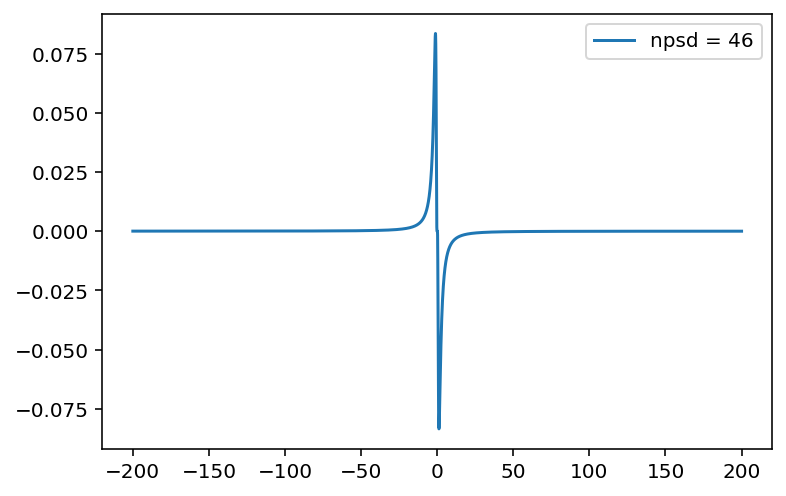

/tmp/ipykernel_392562/4133171827.py:34: RuntimeWarning: overflow encountered in exp
  plt.plot(w, (phi / (1 + np.exp(beta * w))) -


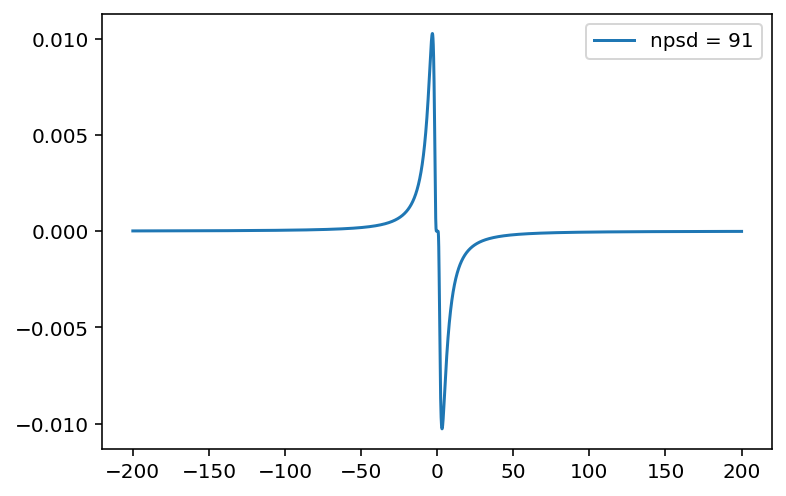

/tmp/ipykernel_392562/4133171827.py:34: RuntimeWarning: overflow encountered in exp
  plt.plot(w, (phi / (1 + np.exp(beta * w))) -


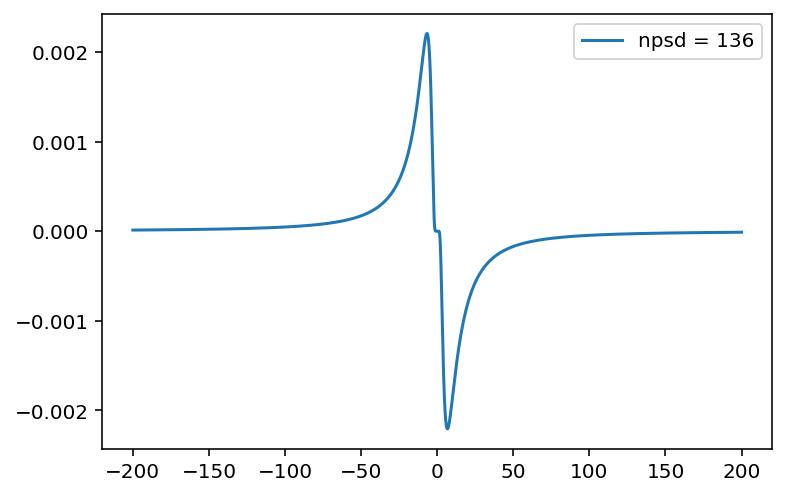

/tmp/ipykernel_392562/4133171827.py:34: RuntimeWarning: overflow encountered in exp
  plt.plot(w, (phi / (1 + np.exp(beta * w))) -


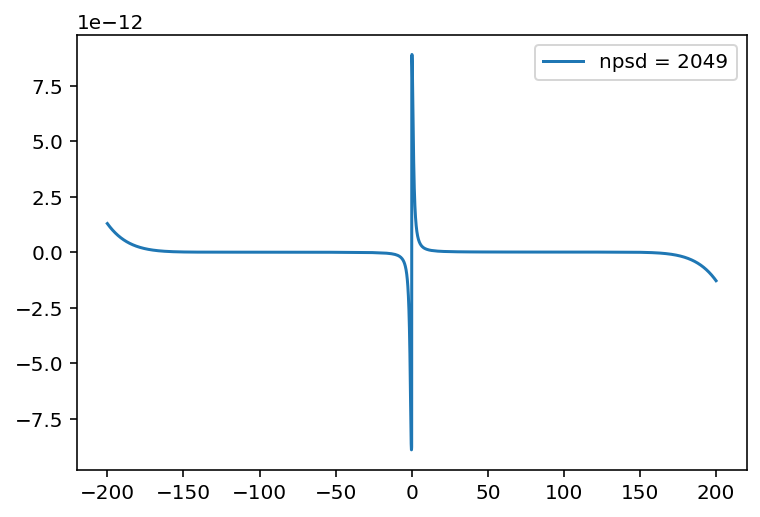

<Figure size 432x288 with 0 Axes>

In [4]:
etal_pade_d = {}
expn_pade_d = {}

for npsd in [45, 90, 135, 2048]:
    nmod = 4
    lams = 1
    gams = 1
    omgs = 0
    temp = 0.0001
    beta = int(1 / temp)

    w_sp, lams_sp, gams_sp, omgs_sp, beta_sp = sp.symbols(
        r"\omega , \lambda, \gamma, \Omega, \beta",
        real=True)

    phi_sp = lams_sp * gams_sp**2 / ((w_sp - omgs_sp)**2 + gams_sp**2)
    sp_para_dict = {
        lams_sp: lams,
        gams_sp: gams,
        omgs_sp: omgs,
    }
    condition_dict = {}
    para_dict = {'beta': beta}
    
    etal_pade, etar_pade, etaa_pade, expn_pade = decompose_spe(
        phi_sp, sp_para_dict, para_dict, condition_dict, npsd, -1)
    
    len_ = 10000
    spe_wid = 200
    w = np.linspace(-spe_wid, spe_wid, len_)
    res_w = np.zeros(len(w), dtype=complex)
    phi = lams * gams**2 / (w**2 + gams**2)
    fit_J(w, res_w, expn_pade, etal_pade, 1)
    plt.plot(w, (phi / (1 + np.exp(beta * w))) -
             res_w.real,
             label='npsd = {}'.format(npsd+ 1))
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    etal_pade_d[npsd+ 1] = etal_pade
    expn_pade_d[npsd+ 1] = expn_pade

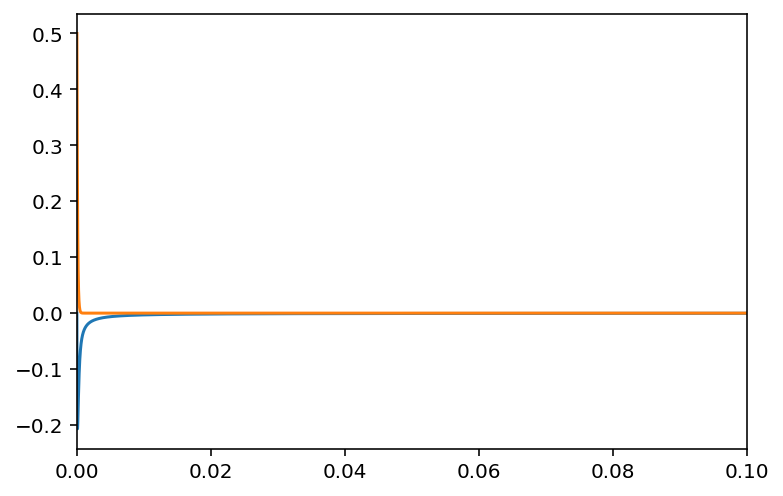

[-9.63283273e-14 -3.27236799e-02 -5.44355812e-02 -7.20174192e-02
 -8.69401041e-02 -9.99063291e-02 -1.11332582e-01 -1.21495852e-01
 -1.30594282e-01 -1.38776961e-01]
[-8.65956900e-06 -8.65950073e-06 -8.65943247e-06 -8.65936420e-06
 -8.65929594e-06 -8.65922767e-06 -8.65915941e-06 -8.65909115e-06
 -8.65902288e-06 -8.65895462e-06]


In [5]:
n = 200000
scale = 10000
n_gamma = npfd

n_sample = n + 1
t = np.linspace(0, 1, 2 * n + 1)
res_t = np.zeros(len(t), dtype=complex)
fit_t(scale * t, res_t, expn_pade, etal_pade)
plt.plot(t, np.imag(res_t))
plt.plot(t, np.real(res_t))
plt.xlim(0,0.1)
plt.show()
h = np.imag(res_t)
print(h[:10])
print(h[-10:])

In [6]:
n_col = n_sample * 2 - 1
n_row = n_gamma + 1
gamma_new_p = np.exp(- expn1 * scale / (2*n))
gamma_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)
for i in range(n_row):
    for j in range(n_col):
        gamma_m[j, i] = np.real(gamma_new_p[i]**j)
        gamma_m[n_col + j, n_row + i] = np.real(gamma_new_p[i]**j)
        gamma_m[j, n_row + i] = -np.imag(gamma_new_p[i]**j)
        gamma_m[n_col + j, i] = np.imag(gamma_new_p[i]**j)

h_m = np.append(np.real(res_t), np.imag(res_t))

freq_d = np.append(
    np.append(np.linspace(-10000, 10, n_col // 2),
              np.linspace(-10, 10, n_col + 1)),
    np.linspace(10, 10000, n_col // 2))

freq_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)
# freq_m = np.linspace(-1000, 1000, 2 * n_col)
# for i in range(n_row):
#     for j in range(2 * n_col):
#         freq_m[j, i] = np.real(expn1[i]) / (np.real(expn1[i])**2 +
#                                             (np.imag(expn1[i]) - freq_d[j])**2)
#         freq_m[j,
#                n_row + i] = (np.imag(expn1[i]) -
#                              freq_d[j]) / (np.real(expn1[i])**2 +
#                                            (np.imag(expn1[i]) - freq_d[j])**2)

C = numpy_to_cvxopt_matrix(gamma_m)
d = numpy_to_cvxopt_matrix(h_m)
A = numpy_to_cvxopt_matrix(-freq_m)
b = numpy_to_cvxopt_matrix(np.zeros(2 * n_col))
Q = C.T * C
q = -d.T * C

opts = {
    'show_progress': True,
    'abstol': 1e-24,
    'reltol': 1e-24,
    'feastol': 1e-24
}
for k, v in opts.items():
    solvers.options[k] = v
sol = solvers.qp(Q, q.T, A, b, None, None, None, None)
omega_new_temp = np.array(sol['x']).reshape(2, n_row)
omega_new_p = omega_new_temp[0, :] + 1.j * omega_new_temp[1, :]

omega_imag = omega_new_p[:1]
omega_real = omega_new_p[1:]

etal_p = np.append(omega_imag, omega_real)
expn_p = expn1.copy()

     pcost       dcost       gap    pres   dres
 0: -5.0618e+00 -5.0618e+00  8e+05  9e+02  5e-17
 1: -5.0618e+00 -5.0618e+00  8e+03  9e+00  5e-17
 2: -5.0618e+00 -5.0618e+00  8e+01  9e-02  1e-16
 3: -5.0618e+00 -5.0618e+00  8e-01  9e-04  1e-16
 4: -5.0618e+00 -5.0618e+00  8e-03  9e-06  1e-16
 5: -5.0618e+00 -5.0618e+00  8e-05  9e-08  7e-17
 6: -5.0618e+00 -5.0618e+00  8e-07  9e-10  8e-17
 7: -5.0618e+00 -5.0618e+00  8e-09  9e-12  7e-17
 8: -5.0618e+00 -5.0618e+00  8e-11  9e-14  1e-16
 9: -5.0618e+00 -5.0618e+00  8e-13  9e-16  1e-16
10: -5.0618e+00 -5.0618e+00  8e-15  9e-18  5e-17
11: -5.0618e+00 -5.0618e+00  8e-17  9e-20  6e-17
12: -5.0618e+00 -5.0618e+00  8e-19  9e-22  6e-17
13: -5.0618e+00 -5.0618e+00  8e-21  9e-24  9e-17
14: -5.0618e+00 -5.0618e+00  8e-23  9e-26  9e-17
15: -5.0618e+00 -5.0618e+00  8e-25  9e-28  7e-17
16: -5.0618e+00 -5.0618e+00  8e-27  9e-30  8e-17
17: -5.0618e+00 -5.0618e+00  8e-29  9e-32  9e-17
18: -5.0618e+00 -5.0618e+00  8e-31  9e-34  7e-17
19: -5.0618e+00 -5.06

/tmp/ipykernel_392562/3628803956.py:7: RuntimeWarning: overflow encountered in exp
  ori_J = lams * gams**2 / (w**2 + gams**2) / (1 + np.exp(beta * w))
/home/dhem/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dhem/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


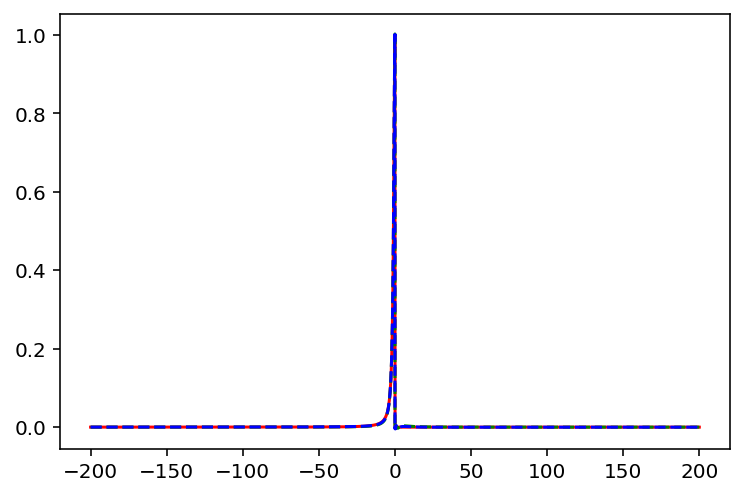

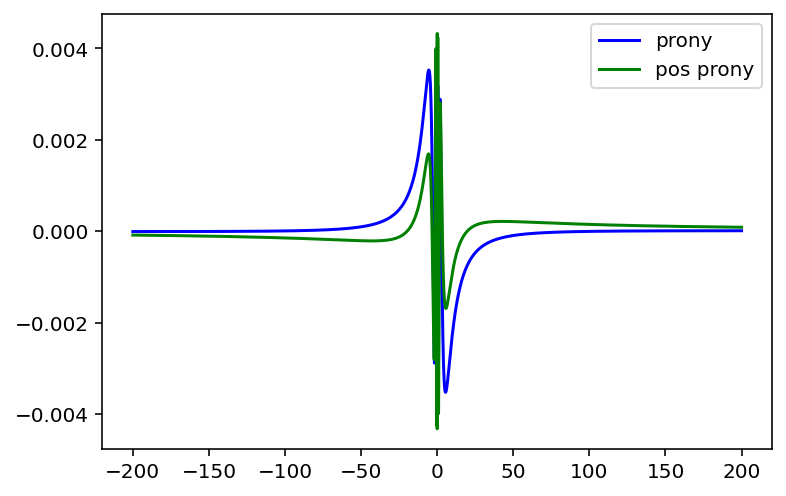

In [7]:
len_ = 100000
spe_wid = 200
w = np.append(np.linspace(-spe_wid, 0, len_),np.linspace(0, spe_wid, len_))
w_sp, lamd_sp, gams_sp, beta_sp = sp.symbols(
    r"\omega , \lambda, \gamma, \beta", real=True)

ori_J = lams * gams**2 / (w**2 + gams**2) / (1 + np.exp(beta * w))

res_J = np.zeros(len(w),dtype=complex)
fit_J(w, res_J, expn1, etal1, 1)
res_Jp = np.zeros(len(w),dtype=complex)
fit_J(w, res_Jp, expn_p, etal_p, 1)

plt.plot(w, ori_J,
         'r',
         label='phixx')
plt.plot(w, res_J,
         'g--',
         label='phixx')
plt.plot(w, res_Jp,
         'b--',
         label='phixx')
plt.show()
plt.clf()

plt.plot(w, ori_J - res_J.real,
         'b',
         label='prony')
plt.plot(w, ori_J - res_Jp.real,
         'g',
         label='pos prony')
plt.legend()

array([2.78740655e+00+0.j, 4.28839664e-01+0.j, 9.02371451e-02+0.j,
       1.96584997e-02+0.j, 4.31172630e-03+0.j, 1.01962506e-03+0.j,
       2.94867229e-04+0.j, 1.00000000e+00-0.j])

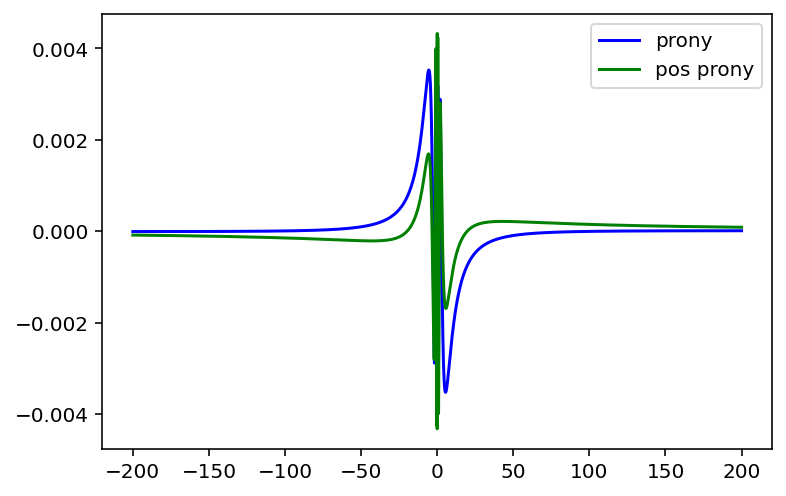

In [8]:
np.savetxt(outputdir + 'etal1_{}'.format(npfd), etal_p)
np.savetxt(outputdir + 'expn1_{}'.format(npfd), expn_p)
plt.plot(w, ori_J - res_J.real,
         'b',
         label='prony')
plt.plot(w, ori_J - res_Jp.real,
         'g',
         label='pos prony')
plt.legend()
plt.savefig(outputdir + 'expn1_{}.pdf'.format(npfd))
expn_p